In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!unzip '/content/drive/MyDrive/Brain Tumor/Brain_Tumor.zip'

Archive:  /content/drive/MyDrive/Brain Tumor/Brain_Tumor.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **Import Libraries**

In [25]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.optimizers import legacy
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img

In [26]:
SAVE = True
SEED = 123

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# # Data Visualization updates
# %config InlineBackend.figure_format = 'retina'
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.rcParams.update({'font.size': 14})

# Data Classifications
classes = os.listdir('/content/Training')
class_len = len(classes)

In [27]:
# Function for importing data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels


In [28]:
train_dir ='/content/Training'
test_dir = '/content/Testing'

train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [29]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

## <b> 5.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Data Augmentation <b>

In [30]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [31]:
def CM(CNN_model, test_generator):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix

    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

### <b> 5.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Data Augmentation Class Indices <b>

In [32]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### <b> 5.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Showing Data Augmentation <b>

In [38]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()


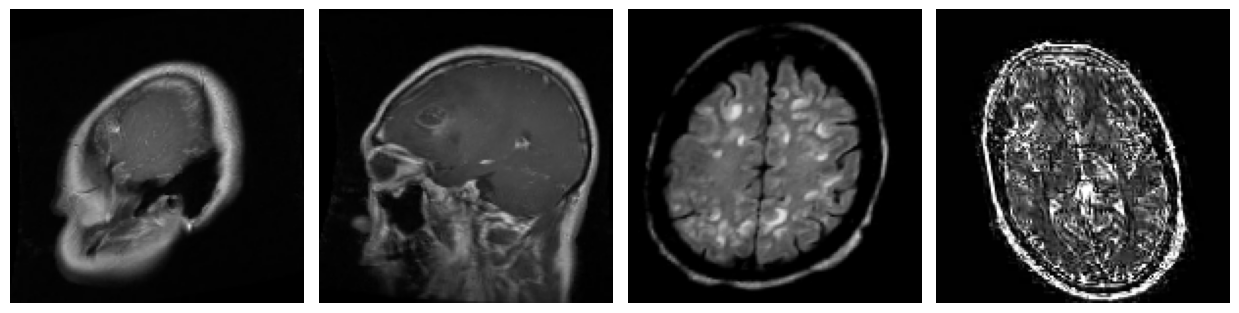

In [39]:
# Showing augmented images
show_ImageDataGenerator(train_datagen,
                        num_samples=4,
                        figsize=(12.5, 8),
                        save=SAVE)

## <b> 5.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Training Setup Values <b>

In [40]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# final model epochs
fm_epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Initial Model Epochs: {epochs}')
print(f'Final Model Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Initial Model Epochs: 40
Final Model Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


# **CNN Model 1**

In [42]:
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(class_len, activation="softmax"))

model_1.summary()

# Compile the model
optimizer = tf.keras.optimizers.Adam()

model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

## <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [ ]:
# Training the model
history_1 = model_1.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4799 - loss: 1.0817 - val_accuracy: 0.7258 - val_loss: 0.7603
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2:35 881ms/step - accuracy: 0.6562 - loss: 0.5978

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.5978 - val_accuracy: 0.7097 - val_loss: 0.7699
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7948 - loss: 0.5078 - val_accuracy: 0.7828 - val_loss: 0.5415
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.5679 - val_accuracy: 1.0000 - val_loss: 0.0627
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8233 - loss: 0.4578 - val_accuracy: 0.8320 - val_loss: 0.4233
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2678 - val_accuracy: 0.9355 - val_loss: 0.3625
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8743 - loss: 0.3385 - val_accuracy: 0.8344 - val_loss: 0.4276
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.5015 - val_accuracy: 0.9677 - val_loss: 0.0899
Epoch 9/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.8998 - loss: 0.2837 - val_accuracy: 0.8266 - 

## <b>  <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [49]:
# Evaluate the model
loss, accuracy = model_1.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 713ms/step - accuracy: 0.9633 - loss: 0.0941
Test Loss: 0.07533
Test Accuracy: 0.97266


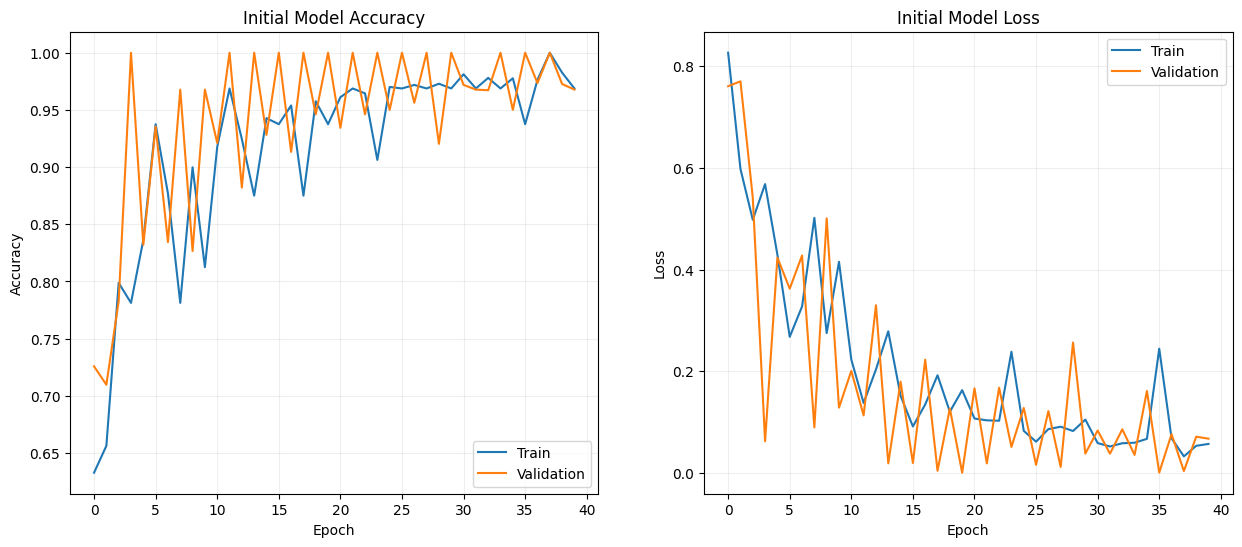

In [50]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Initial Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Initial Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)
if SAVE:
    plt.savefig('model_1_acc_loss.pdf')
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have predictions and true labels after training
predictions = model_1.predict(test_generator)
true_labels = test_generator.classes

# Convert predictions to classes (assuming one-hot encoding)
predicted_classes = np.argmax(predictions, axis=1)


#print(conf_matrix)

# Calculate and display classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("\n CNN Model-1 Classification Report:")
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 395ms/step

 CNN Model-1 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.91      0.98      0.94       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# **Confusion Matrix**

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step


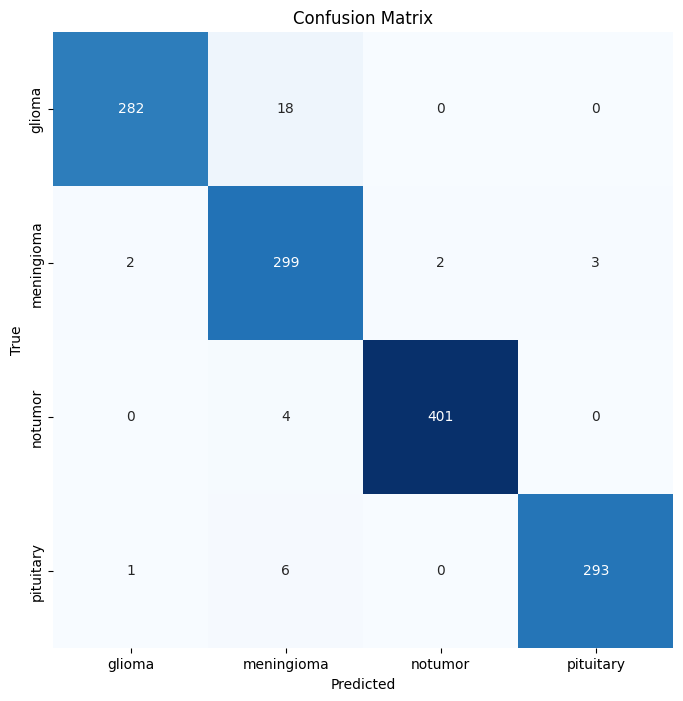

In [52]:
# Plotting confusion matrix
confusion_matrix_1 = CM(CNN_model=model_1, test_generator=test_generator)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(class_len) + 0.5, labels=class_indices_train_list, ha='center')
plt.yticks(ticks=np.arange(class_len) + 0.5, labels=class_indices_train_list, va='center')
if SAVE:
    plt.savefig('CM_plot_1.pdf')
plt.show()


# **CNN Model  2**

In [55]:
# Define the model architecture
model_2 = models.Sequential()

# Convolutional layer 1
model_2.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_2.add(Conv2D(64, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(Flatten())

# Full connect layers
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.5, seed=SEED))
model_2.add(Dense(class_len, activation="softmax"))

model_2.summary()
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

## <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [56]:
# Stop training if loss doesn't keep decreasing.
model_2_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_2_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_2 = model_2.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks=[model_2_es, model_2_rlr])


Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.4981 - loss: 1.0614 - val_accuracy: 0.6461 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4:28 2s/step - accuracy: 0.7812 - loss: 0.6739

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7812 - loss: 0.6739 - val_accuracy: 1.0000 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7747 - loss: 0.5555 - val_accuracy: 0.7445 - val_loss: 0.5940 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.4360 - val_accuracy: 0.9032 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8336 - loss: 0.4349 - val_accuracy: 0.8047 - val_loss: 0.4579 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 0.4223 - val_accuracy: 0.9677 - val_loss: 0.0947 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8680 - loss: 0.3411 - val_accuracy: 0.8430 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8750 - loss: 0.2636 - val_ac

In [57]:
model_file = '/content/drive/MyDrive/CNN_Brain_Tumor/CNN_99_model_2.h5'
history_file = '/content/drive/MyDrive/CNN_Brain_Tumor/history_2.npy'

# Checking for model
if not os.path.exists(model_file):

    # Saving model
    model_2.save(model_file)
    history_dict = history_2.history

    # Save training history as a .npy file
    np.save(history_file, history_dict)

else:
    print('Model exists, please delete if you want to update it.')


In [58]:
model_file = '/content/drive/MyDrive/CNN_Brain_Tumor/CNN_99_model_2.h5'
history_file = '/content/drive/MyDrive/CNN_Brain_Tumor/history_2.npy'

# Check if model was created
if os.path.exists(model_file):

    # Loading model 2
    model_2 = models.load_model(model_file)

    # Load the training history from the .npy file
    history_dict = np.load(history_file, allow_pickle=True).item()
    df_history_model_2 = pd.DataFrame(history_dict)
    display( df_history_model_2.head(5) )
    display( df_history_model_2.tail(5) )


,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.617606,0.847722,0.646094,0.894545,0.001
1,0.781250,0.673854,1.000000,0.203742,0.001
2,0.789965,0.517447,0.744531,0.593984,0.001
3,0.750000,0.436027,0.903226,0.324329,0.001
4,0.840141,0.421938,0.804688,0.457918,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
33,1.000000,0.019252,1.000000,0.005889,0.000027
34,0.987148,0.038199,0.975000,0.079556,0.000027
35,1.000000,0.026376,1.000000,0.011924,0.000027
36,0.987500,0.036872,0.975781,0.075317,0.000008
37,1.000000,0.044121,1.000000,0.007907,0.000008


## <b><span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [59]:
# Evaluating the model
loss, accuracy = model_2.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.9639 - loss: 0.1031
Test Loss: 0.07520
Test Accuracy: 0.97578


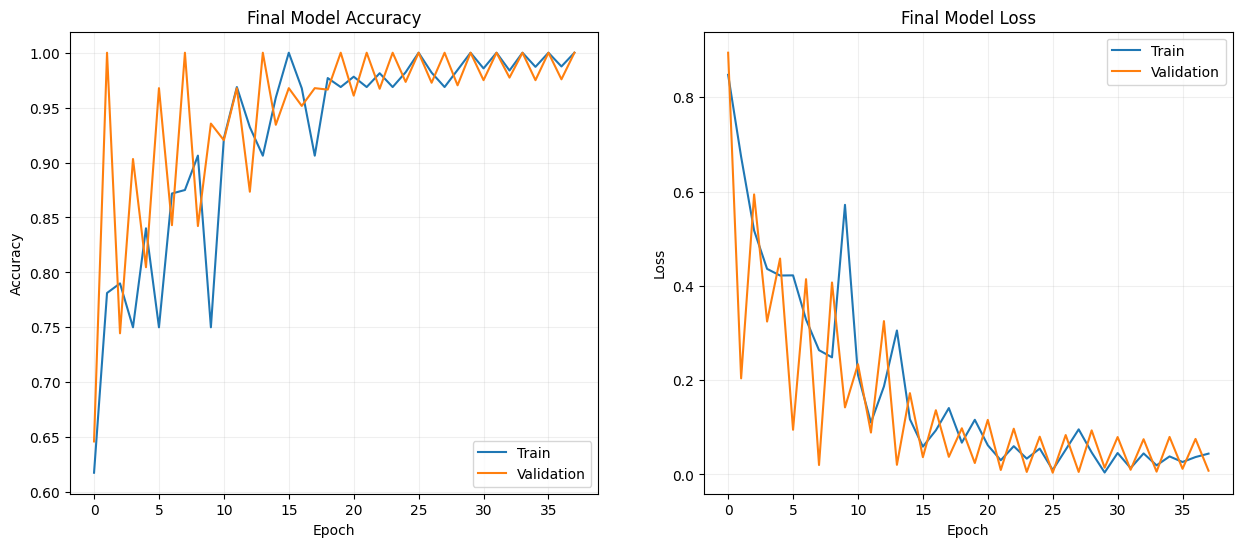

In [60]:
# checking if from save file or just ran model
if os.path.exists(model_file):
    history = history_dict

else:
    history = history_2.histor

# creating subplots
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Final Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Final Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)
if SAVE:
    plt.savefig('model_2_acc_loss.pdf')
plt.show()

In [61]:

# Assuming you have predictions and true labels after training
predictions = model_2.predict(test_generator)
true_labels = test_generator.classes

# Convert predictions to classes (assuming one-hot encoding)
predicted_classes = np.argmax(predictions, axis=1)


#print(conf_matrix)

# Calculate and display classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("\n CNN Model-2 Classification Report:")
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step

 CNN Model-2 Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       300
  meningioma       0.96      0.95      0.96       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.98      1311
weighted avg       0.98      0.98      0.98      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step


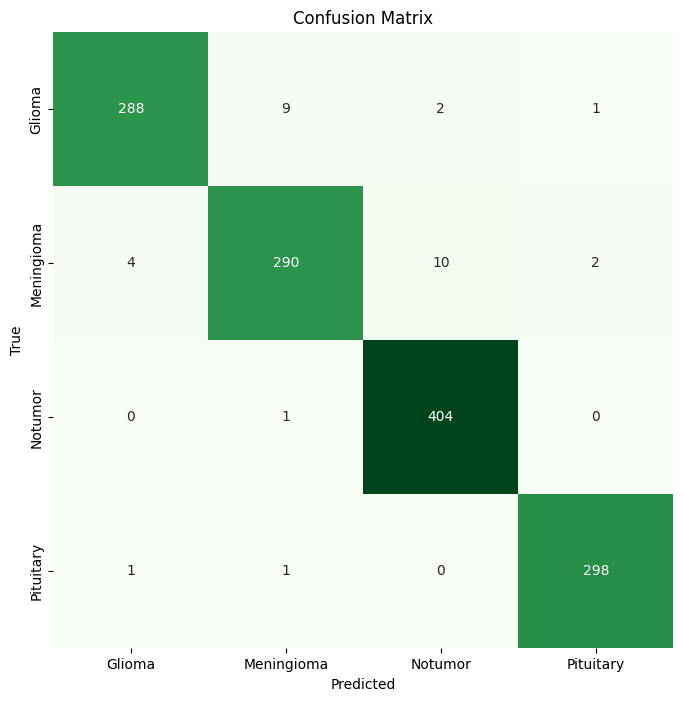

In [62]:
# Plotting confusion matrix

confusion_matrix_2 = CM(CNN_model=model_2, test_generator=test_generator)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_2, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(class_len) + 0.5,
           labels=[name.title() for name in class_indices_train_list],
           ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in class_indices_train_list],
           va='center')
if SAVE:
    plt.savefig('CM_plot_2.pdf')
plt.show()

# **Prediction**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


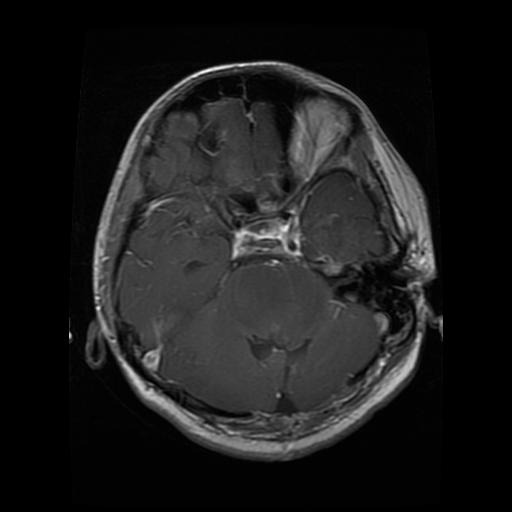

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Prediction Class :  glioma


In [63]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import cv2
import pickle
from google.colab.patches import cv2_imshow
# Load the saved model without the top layers
model = load_model('/content/drive/MyDrive/Brain Tumor/CNN_99_model_2.h5', compile=False)

# Get the index of the flatten layer
flatten_layer_index = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, Flatten):
        flatten_layer_index = i
        break

if flatten_layer_index is None:
    raise ValueError("Flatten layer not found in the model")


img_path='/content/Te-gl_0010.jpg'
image=cv2.imread(img_path)
cv2_imshow(image)
#print(image.shape)
image=cv2.resize(image,(150,150))
#print(image.shape)
image=(image/255).reshape(1,image.shape[0],image.shape[1], -1)
# Extract features using the feature_extractor_model
prediction = model.predict(image)
prediction_val=np.argmax(prediction)


prediction_label={0:'glioma',1:'meningioma',2:'no_tumor',3:'pituitary'}
print("Prediction Class : ",prediction_label.get(prediction_val))